# Compare planet SNR between epochs
 

## Author: Jason Wang 
## Coauthor : Tanmoy Bhowmik 

## Objective

We will use the pyklip package to subtract off the glare of the star and measure the position and brightness of the exoplanet.

## Keyword: pyklip,subtract , psf


### Required dependencies
* Python modules
* python 3
* astropy
* numpy
* matplotlib
* scipy
* pyklip

# pyklip installation

In [20]:
!pip install pyklip

# Import Packages

In [69]:
import numpy as np
import astropy.io.fits as fits
import scipy.ndimage
import pyklip.klip
import pyklip.parallelized
import pyklip.instruments.Instrument as Instrument
import pyklip.fakes
import pyklip.kpp.metrics.crossCorr
import pyklip.kpp.stat.statPerPix_utils
import matplotlib.pylab as plt
%matplotlib inline

# Read in the necessary data
We will read in three different files:

A time series of the science data. This is a 3-D image cube consisting of images of the system taken over time. The sky rotates over this period of time due to angular differential imaging. If you look really carefully, you can actually see a couple of planets!

An image of the star not blocked by the coronagraph, so we can measure the flux of the star. This is needed to measure flux ratio between the planet and the star.

A 1-D array of parallactic angles. These angles specify the rotation of the sky for each frame in the 3-D image cube due to the Earth's rotation. These are needed to derotate the images so we can stack the signal of the planet together on the same pixel.

Credit to William Thompson (https://www.astro.uvic.ca/~wthompson/) for reducing these HR 8799 datasets and putting them online for us.

Text(0.5, 1.0, 'Calibration Frame')

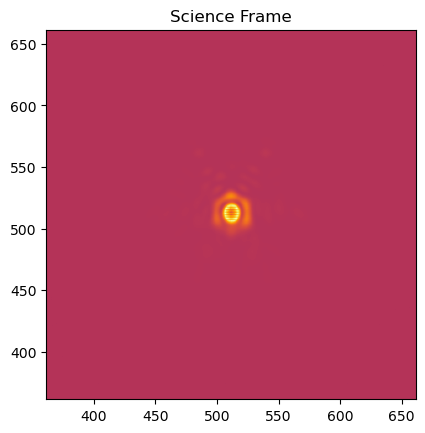

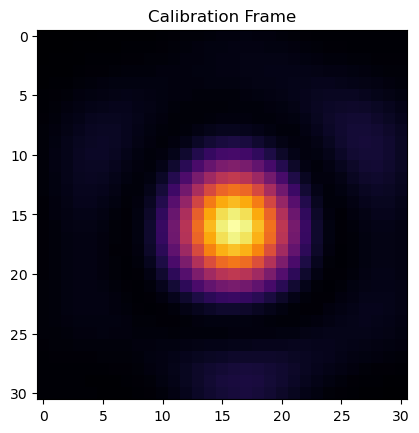

In [62]:
# load in the science frames for imaging the planet
with fits.open("center_im.fits") as hdulist:
    img_cube = hdulist[0].data # Series of images of the star system taken in time
    exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star behind the coronagraph based on the documentaion
star_centx = (img_cube.shape[2]-1)/2
star_centy = (img_cube.shape[1]-1)/2

# load in the calibration frame to calibrate the brightness of any sources with respect to the star
with fits.open("median_unsat.fits") as hdulist:
    calib_frame = hdulist[0].data # image of the unsaturated star for photometric calibration
    # crop it down because we don't need it so big
    calib_orig_cent = ((calib_frame.shape[0] - 1) // 2, (calib_frame.shape[1] - 1) // 2)
    stamprad = 15
    calib_frame = calib_frame[calib_orig_cent[0]-stamprad:calib_orig_cent[0]+stamprad+1, calib_orig_cent[1]-stamprad:calib_orig_cent[1]+stamprad+1]
    calib_exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star in the calibration frame
calib_centx = (calib_frame.shape[1]-1)/2
calib_centy = (calib_frame.shape[0]-1)/2

# the parallactic angles corresponding to each frame for angular differential imaging
with fits.open("rotnorth.fits") as hdulist:
    rot_angles = hdulist[0].data # negative signs are tricky

plt.figure()
plt.imshow(img_cube[0], cmap="inferno")
plt.xlim([star_centx-150, star_centx+150])
plt.ylim([star_centy-150, star_centy+150])
plt.title("Science Frame")

plt.figure()
plt.imshow(calib_frame, cmap="inferno")
plt.title("Calibration Frame")

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 11


  0%|          | 0/11 [00:00<?, ?it/s]

Closing threadpool
Derotating Images...
Writing Images to directory C:\Users\USER\Downloads
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 69, 1, 1024, 1024)


C:\Users\USER\AppData\Local\Temp\ipykernel_9688\1352331317.py:13: RuntimeWarning: Mean of empty slice
  output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time


Text(0.5, 1.0, 'Stellar PSF Subtracted Image')

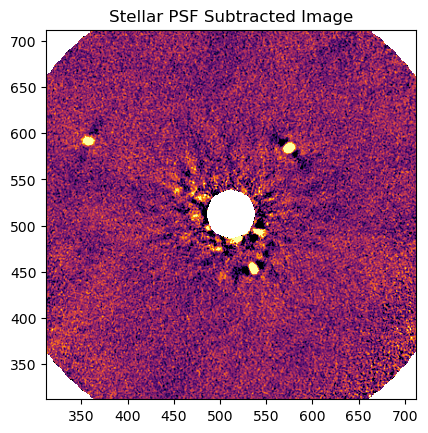

In [63]:
centers = np.array([[star_centx, star_centy] for _ in range(img_cube.shape[0])])

dataset = Instrument.GenericData(img_cube, centers, parangs=rot_angles)
dataset.IWA = 25
dataset.OWA = 250

pyklip.parallelized.klip_dataset(dataset, outputdir="./", fileprefix="epoch2", annuli=11,
                                 subsections=1, numbasis=[1,3,5,10,20,30], maxnumbasis=100, mode="ADI",
                                 movement=1)

output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time

plt.figure()
plt.imshow(output_img, cmap="inferno", vmin=np.nanpercentile(output_img, 1), vmax=np.nanpercentile(output_img, 99.7))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])
plt.title("Stellar PSF Subtracted Image")

C:\Users\USER\AppData\Local\Temp\ipykernel_9688\4059859350.py:1: RuntimeWarning: Mean of empty slice
  output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time


Text(0.5, 1.0, '2021: Stellar PSF Subtracted Image')

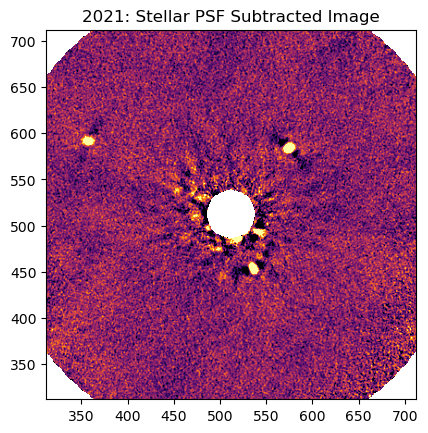

In [64]:
output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time

plt.figure()
plt.imshow(output_img, cmap="inferno", vmin=np.nanpercentile(output_img, 1), vmax=np.nanpercentile(output_img, 99.7))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])
plt.title("2021: Stellar PSF Subtracted Image")

I would say this 2021 image looks like it has an ever so slightly worse detection of HR 8799 c.

Now let's measure SNR

# For planet Position

In [66]:

guess_x, guess_y = 395, 450
guess_flux = 800

raw_peakflux, fwhm, planet_x, planet_y = pyklip.fakes.gaussfit2d(output_img, guess_x, guess_y, guesspeak=guess_flux)
print(raw_peakflux, fwhm, planet_x, planet_y)

star_y, star_x = dataset.output_centers[0]

planet_sep_pixels = np.sqrt((planet_x - star_x)**2 + (planet_y - star_y)**2)
planet_PA = np.degrees(np.arctan2(-(planet_x - star_x), planet_y - star_y)) % 360

platescale = 9.952 # mas/pixel
planet_sep_mas = planet_sep_pixels * platescale

print("Planet separation: {0:.2f} mas. Planet PA: {1:.2f} deg".format(planet_sep_mas, planet_PA))

-68.63583515090657 1.6201894735406495 393.4587058633794 448.5137170213384
Planet separation: 1338.26 mas. Planet PA: 118.17 deg


(312.0, 712.0)

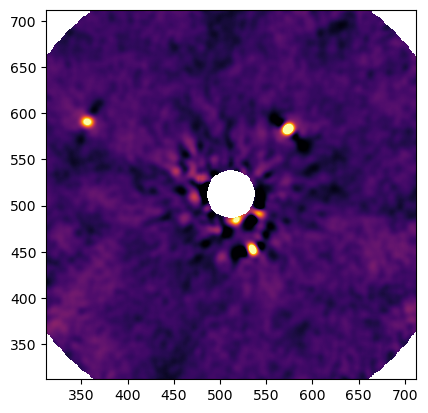

In [67]:
# cross correlate
# use the unocculted image of the star to create a template PSF
# we're just going to make a rough cutout to keep things simple
calib_centy_int = int(np.round(calib_centy))
calib_centx_int = int(np.round(calib_centx))
template = calib_frame[calib_centy_int-10:calib_centy_int+11, calib_centx_int-10:calib_centx_int+11]

# perform a cross correlation of the image with a planet template to get a cross correlation map
# this helps us filter out noise
cc_map = pyklip.kpp.metrics.crossCorr.calculate_cc(output_img, template, nans2zero=True)

plt.imshow(cc_map, cmap="inferno", vmin=np.nanpercentile(cc_map, 0.5), vmax=np.nanpercentile(cc_map, 99.9))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])

C:\Users\USER\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[0.04575135]


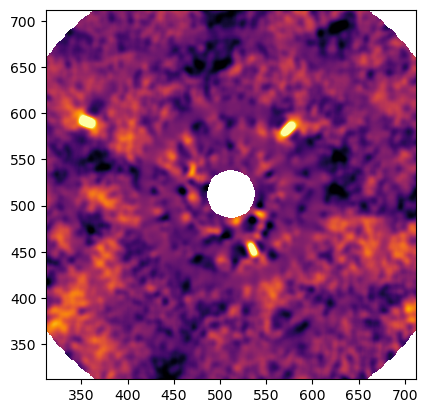

In [68]:

SNR_map = pyklip.kpp.stat.statPerPix_utils.get_image_stat_map(cc_map,
                                           centroid = dataset.output_centers[0],
                                           r_step=2,
                                           Dr = 2,
                                           type = "SNR")

plt.imshow(SNR_map, cmap="inferno", vmin=-2.5, vmax=5)
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])


# read off the SNR map to get the SNR of the planet you care about.
# we will perform the "read off" using a linear interpolation to the centroid location of the planet

SNR_map[np.where(np.isnan(SNR_map))] = 0 # have to mask NaNs for this to work
planet_snr = scipy.ndimage.map_coordinates(SNR_map, [[planet_y], [planet_x]])
print(planet_snr)